In [132]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [133]:
#brent oil
#https://www.kaggle.com/datasets/mabusalah/brent-oil-prices
#05/1987 - 11/2022
df = pd.read_csv("BrentOilPrices.csv")

In [134]:
df.Price

0       18.63
1       18.45
2       18.55
3       18.60
4       18.63
        ...  
9006    96.85
9007    93.05
9008    94.25
9009    96.37
9010    93.59
Name: Price, Length: 9011, dtype: float64

In [135]:
def estimate_python(data, k=5):
    "A slow pure python implementation"
    prices = data['Price'].to_numpy(dtype=np.float64)
    log_prices = np.log(prices)
    rets = np.diff(log_prices)
    T = len(rets)
    mu = np.mean(rets)
    var_1 = np.var(rets, ddof=1, dtype=np.float64)
    rets_k = (log_prices - np.roll(log_prices, k))[k:]
    m = k * (T - k + 1) * (1 - k / T)
    var_k = 1/m * np.sum(np.square(rets_k - k * mu))

    # Variance Ratio
    vr = var_k / var_1
    # Phi1
    phi1 = 2 * (2*k - 1) * (k-1) / (3*k*T)
    # Phi2

    def delta(j):
        res = 0
        for t in range(j+1, T+1):
            t -= 1  # array index is t-1 for t-th element
            res += np.square((rets[t]-mu)*(rets[t-j]-mu))
        return res / ((T-1) * var_1)**2

    phi2 = 0
    for j in range(1, k):
        phi2 += (2*(k-j)/k)**2 * delta(j)

    return vr, (vr - 1) / np.sqrt(phi1), (vr - 1) / np.sqrt(phi2)


In [136]:
estimate_python(df,k=10)

(0.9491134212400386, -1.4305835369325148, -0.4278414051495417)

In [137]:
# LoMacKinlay.py
import numpy as np
from numba import jit

name = 'LoMacKinlay1988'
description = 'Variance ratio and test statistics as in Lo and MacKinlay (1988)'
vars_needed = ['Price']


@jit(nopython=True, nogil=True, cache=True)
def _estimate(log_prices, k, const_arr):
    # Log returns = [x2, x3, x4, ..., xT], where x(i)=ln[p(i)/p(i-1)]
    rets = np.diff(log_prices)
    # T is the length of return series
    T = len(rets)
    # mu is the mean log return
    mu = np.mean(rets)
    # sqr_demeaned_x is the array of squared demeaned log returns
    sqr_demeaned_x = np.square(rets - mu)
    # Var_1
    # Didn't use np.var(rets, ddof=1) because
    # sqr_demeaned_x is calculated already and will be used many times.
    var_1 = np.sum(sqr_demeaned_x) / (T-1)
    # Var_k
    # Variance of log returns where x(i) = ln[p(i)/p(i-k)]
    # Before np.roll() - array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    # After np.roll(,shift=2) - array([8, 9, 0, 1, 2, 3, 4, 5, 6, 7])
    # Discard the first k elements.
    rets_k = (log_prices - np.roll(log_prices, k))[k:]
    m = k * (T - k + 1) * (1 - k / T)
    var_k = 1/m * np.sum(np.square(rets_k - k * mu))

    # Variance Ratio
    vr = var_k / var_1

    # a_arr is an array of { (2*(k-j)/k)^2 } for j=1,2,...,k-1, fixed for a given k:
    #   When k=5, a_arr = array([2.56, 1.44, 0.64, 0.16]).
    #   When k=8, a_arr = array([3.0625, 2.25, 1.5625, 1., 0.5625, 0.25, 0.0625])
    # Without JIT it's defined as:
    #   a_arr = np.square(np.arange(k-1, 0, step=-1, dtype=np.int) * 2 / k)
    # But np.array creation is not allowed in nopython mode.
    # So const_arr=np.arange(k-1, 0, step=-1, dtype=np.int) is created outside.
    a_arr = np.square(const_arr * 2 / k)

    # b_arr is part of the delta_arr.
    b_arr = np.empty(k-1, dtype=np.float64)
    for j in range(1, k):
        b_arr[j-1] = np.sum((sqr_demeaned_x *
                             np.roll(sqr_demeaned_x, j))[j:]) #

    delta_arr = b_arr / np.square(np.sum(sqr_demeaned_x))

    # Both arrarys are of length (k-1)
    assert len(delta_arr) == len(a_arr) == k-1

    phi1 = 2 * (2*k - 1) * (k-1) / (3*k*T)
    phi2 = np.sum(a_arr * delta_arr)

    # VR test statistics under two assumptions
    vr_stat_homoscedasticity = (vr - 1) / np.sqrt(phi1)
    vr_stat_heteroscedasticity = (vr - 1) / np.sqrt(phi2)

    return vr, vr_stat_homoscedasticity, vr_stat_heteroscedasticity


def estimate(data):
    "A fast estimation of Variance Ratio test statistics as in Lo and MacKinlay (1988)"
    # Prices array = [p1, p2, p3, p4, ..., pT]
    prices = data['Price'].to_numpy(dtype=np.float64)
    result = []
    # Estimate many lags.
    for k in [2, 4, 6, 8, 10, 15, 20, 30, 40, 50, 100, 200, 500, 1000]:
        # Compute a constant array as np.array creation is not allowed in nopython mode.
        const_arr = np.arange(k-1, 0, step=-1, dtype=np.int64) #
        vr, stat1, stat2 = _estimate(np.log(prices), k, const_arr)
        result.append({
            f'Variance Ratio (k={k})': vr,
            f'Variance Ratio Test Statistic (k={k}) Homoscedasticity Assumption': stat1,
            f'Variance Ratio Test Statistic (k={k}) Heteroscedasticity Assumption': stat2
        })
    return result


In [138]:
res = estimate(df)
print(res)

[{'Variance Ratio (k=2)': 0.9863036638632829, 'Variance Ratio Test Statistic (k=2) Homoscedasticity Assumption': -1.3000701936300108, 'Variance Ratio Test Statistic (k=2) Heteroscedasticity Assumption': -0.2581599333100608}, {'Variance Ratio (k=4)': 0.9596750310053007, 'Variance Ratio Test Statistic (k=4) Homoscedasticity Assumption': -2.04598485897591, 'Variance Ratio Test Statistic (k=4) Heteroscedasticity Assumption': -0.4819108527305605}, {'Variance Ratio (k=6)': 0.9504636407301068, 'Variance Ratio Test Statistic (k=6) Homoscedasticity Assumption': -1.902069536282974, 'Variance Ratio Test Statistic (k=6) Heteroscedasticity Assumption': -0.5051587903539871}, {'Variance Ratio (k=8)': 0.9390234274892248, 'Variance Ratio Test Statistic (k=8) Homoscedasticity Assumption': -1.956687082958861, 'Variance Ratio Test Statistic (k=8) Heteroscedasticity Assumption': -0.5580480747908017}, {'Variance Ratio (k=10)': 0.9491134212400385, 'Variance Ratio Test Statistic (k=10) Homoscedasticity Assump

observation: k increases, variance ratio decreases

In [139]:
import seaborn as sns
#January 2, 2002–July 7, 2006???
startdate = '2002-01-02'
enddate = '2006-07-07'
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df.Date >= startdate) & (df.Date <= enddate)]
#plt.plot(df.Date,df.Price)
#df['Delta'] = df.Price.diff()
df = df.iloc[:,1:]
df

,Date,Price
3710,2002-01-02,20.13
3711,2002-01-03,20.47
3712,2002-01-04,21.20
3713,2002-01-07,21.08
3714,2002-01-08,21.03
...,...,...
4868,2006-07-03,73.94
4869,2006-07-04,73.17
4870,2006-07-05,72.88
4871,2006-07-06,73.12


In [148]:
df.resample('M', on='Date').mean()
plt.plot(df.)

,Price,Return,Log_return
Date,,,
2002-01-31,19.416818,-0.050476,-0.002576
2002-02-28,20.275500,0.083000,0.004173
2002-03-31,23.696667,0.219524,0.009562
2002-04-30,25.728636,0.074545,0.002851
2002-05-31,25.345455,-0.141364,-0.005567
2002-06-30,24.081667,0.081111,0.003298
2002-07-31,25.736087,0.041304,0.001601
2002-08-31,26.651364,0.058182,0.002162
2002-09-30,28.399524,0.073810,0.002606


0.001121982752212466

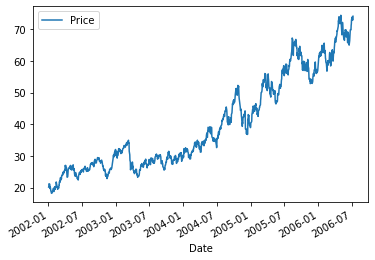

In [142]:
ax = df.plot(kind='line', x='Date', y='Price')
df['Return'] = df.Price.diff()
df['Log_return'] = np.log(df.Price).diff()
np.mean(df.Log_return)
np.st

In [141]:
import statsmodels.tsa.stattools as ts
adf = ts.adfuller(df.Price, 1)
print(adf)

(-0.13704379184529206, 0.945621533167043, 0, 1162, {'1%': -3.4359901072390353, '5%': -2.86403051064684, '10%': -2.5680960046332366}, 2993.3481045495255)
